In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import numpy as np
import argparse
import wandb
from tqdm import tqdm
from PIL import Image

import utils

from datasets import ImageDataset
from mlnet import MLNet

加载数据

In [2]:
root = '/data/SALICON'

transforms_ = transforms.Compose([
    transforms.Resize((256,256), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.471, 0.448, 0.408), std=(0.234, 0.239, 0.242))
])

dataset = ImageDataset(root=root, split='val', transform=transforms_)
dataloader = DataLoader(dataset, batch_size=5)

/home/xieshaoyuan/anaconda3/envs/pointnet/lib/python3.6/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [3]:
ckp_path = './checkpoint/checkpoint_best.pt'
checkpoint = torch.load(ckp_path, map_location='cpu')
checkpoint_model = checkpoint['state_dict']

model = MLNet()
model.load_state_dict(checkpoint_model)
model.cuda()
model.eval()

MLNet(
  (block_1): Sequential(
    (0): VGGBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Maxpool()
  )
  (block_2): Sequential(
    (0): VGGBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Maxpool()
  )
  (block_3): Sequential(
    (0): VGGBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNo

In [15]:
for i, data in enumerate(dataloader):
    imgs, maps = data
    imgs = imgs.cuda()
    maps = maps.cuda()

    output = model(imgs)
    break

/home/xieshaoyuan/anaconda3/envs/pointnet/lib/python3.6/site-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

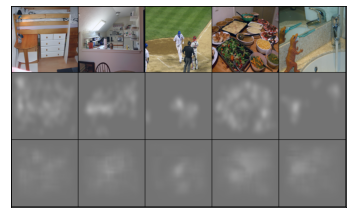

In [16]:
result = torch.cat((imgs, maps.repeat(1,3,1,1), output.repeat(1,3,1,1)), dim=0)
grid = make_grid(result, nrow=5, normalize=True)
show(grid)